# Forward projection of a “point by point” grain map
A quick experiment to see whether we can compute something like images to compare to the
experimental data for validation.
The idea is to pick the best grain at each point, then compute the spots coming from that voxel.
These are plotted onto pole figures in azimuth / omega space to easily compare to reduced data
frm frames. Also as sinograms, with one for each hkl ring.
Some other notebook will be set up to prepare the experimental data into such a format.

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"
import sys
from matplotlib import pyplot as plt
import numpy as np
import ImageD11.sinograms.dataset
import ImageD11.sinograms.tensor_map
import ImageD11.sinograms.geometry
import time

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

start_time = time.time()

In [2]:
# make a small map

In [3]:
asc = ImageD11.unitcell.Phases.from_json('pars.json')
ucell = asc.unitcells['Cu']
ucell

Cu | [ 3.615  3.615  3.615 90.    90.    90.   ] | 225

In [4]:
ucell.B

array([[ 2.76625173e-01, -1.05907848e-16, -1.05907848e-16],
       [ 0.00000000e+00,  2.76625173e-01, -1.69384066e-17],
       [ 0.00000000e+00,  0.00000000e+00,  2.76625173e-01]])

In [5]:
from scipy.spatial.transform import Rotation as R

In [6]:
U = R.random().as_matrix()
U

array([[ 0.76615596,  0.25677522,  0.58912777],
       [ 0.39180361,  0.54000802, -0.74490353],
       [-0.50940649,  0.80153467,  0.31312491]])

In [7]:
# generate a twin variant

In [8]:
import scipy

def make_sigma3_mats( ):
    """ Rotations of 60 degrees on 111 """
    v = 60/np.sqrt( 3 )
    S3_matrices = [ scipy.spatial.transform.Rotation.from_rotvec( (x,y,z), degrees=True ).as_matrix()
            for x in (-v,v)
            for y in (-v,v)
            for z in (-v,) ]  # only need 1 z as -60 == 60
    return S3_matrices

matrices = make_sigma3_mats()

def applytwinmat( g, mat ):
    """ U.B -> U.M'.B """
    ubinew = np.linalg.inv( g.U.dot( mat.T ).dot( g.B ) )
    return ImageD11.grain.grain( ubinew, g.translation )

In [9]:
base_grain = ImageD11.grain.grain(np.linalg.inv(U @ ucell.B))

In [10]:
twin_grain = applytwinmat(base_grain, matrices[0])

In [11]:
base_grain.U, twin_grain.U

(array([[ 0.76615596,  0.25677522,  0.58912777],
        [ 0.39180361,  0.54000802, -0.74490353],
        [-0.50940649,  0.80153467,  0.31312491]]),
 array([[ 0.4855782 ,  0.30855   ,  0.81793075],
        [ 0.86950893, -0.26719821, -0.41540262],
        [ 0.09037715,  0.91290855, -0.39803261]]))

In [12]:
# assert it's 60 degrees about (111)
rotvec = R.from_matrix(base_grain.U.T @ twin_grain.U).as_rotvec()
rotvec, np.degrees(np.linalg.norm(rotvec))

(array([0.60459979, 0.60459979, 0.60459979]), 60.00000000000002)

In [13]:
# make a map

In [14]:
NY = 200
UB_field = np.full((NY, NY, 3, 3), fill_value=np.nan)

In [15]:
NY = 200
UB_field = np.full((NY, NY, 3, 3), fill_value=np.nan)
UB_field[50:-50, 50:-50] = base_grain.UB
UB_field[75:80, 75:125] = twin_grain.UB

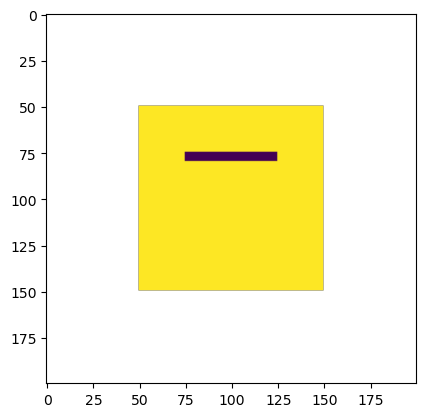

In [16]:
fig, ax = plt.subplots()
ax.imshow(UB_field[..., 0, 0])
plt.show()

In [17]:
UB_recon_space = UB_field

In [18]:
# get a mask to the UB map in reconstruction shape
todo = ~np.isnan(UB_recon_space[:,:,0,0])

Text(0.5, 1.0, 'Active voxels')

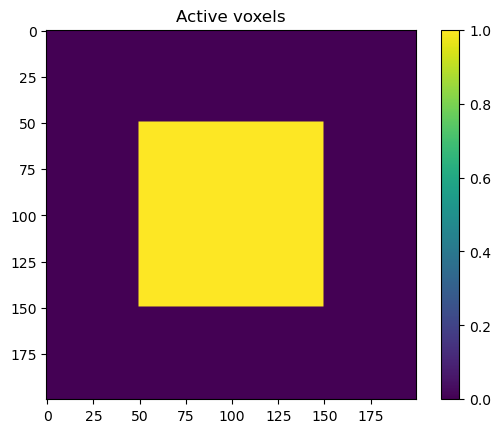

In [19]:
plt.figure()
plt.imshow(todo)
plt.colorbar()
plt.title("Active voxels")

In [20]:
ref_ucell = ucell

In [21]:
dsmax = 2.5

In [22]:
# generate array of all symmetry-allowed hkls

ref_ucell.makerings(dsmax)
hkls = []
mults = []
for d in ref_ucell.ringds:
    hklring = ref_ucell.ringhkls[d]
    mults.append( len(hklring) )
    print(len(hklring),hklring[0],d)
    hkls += list(hklring)

8 (-1, -1, -1) 0.47912885409927447
6 (0, -2, 0) 0.5532503457814661
12 (-2, 0, -2) 0.7824141423917538
24 (-1, -3, -1) 0.9174619060457537
8 (-2, -2, -2) 0.9582577081985489
6 (0, -4, 0) 1.1065006915629323
24 (-1, -3, -3) 1.2057811738701725
24 (-2, -4, 0) 1.2371053817426223
24 (-2, -2, -4) 1.3551810471829477
32 (-3, -3, -3) 1.4373865622978232
12 (0, -4, -4) 1.5648282847835076
48 (-1, -5, -3) 1.6365365928353015
30 (-6, 0, 0) 1.6597510373443982
24 (0, -2, -6) 1.7495312089451613
24 (-5, -3, -3) 1.8139525655053943
24 (-2, -6, -2) 1.8349238120915075
8 (-4, -4, -4) 1.9165154163970979
48 (-5, -1, -5) 1.9754988737324617
24 (0, -6, -4) 1.994772489883258
48 (-6, -2, -4) 2.07007324302846
72 (-5, -3, -5) 2.1247982705030726
6 (0, -8, 0) 2.2130013831258646
24 (-7, -3, -3) 2.2642746256908572
48 (-8, -2, 0) 2.2811096130664787
36 (0, -6, -6) 2.3472424271752614
56 (-7, -5, -1) 2.3956442704963723
24 (-6, -6, -2) 2.411562347740345
24 (-4, -8, 0) 2.4742107634852446


In [23]:
hkls = np.array(hkls)
print(hkls)
hkls.shape

[[-1 -1 -1]
 [-1 -1  1]
 [-1  1 -1]
 ...
 [ 0  8  4]
 [ 8  4  0]
 [ 4  8  0]]


(748, 3)

In [24]:
# mask UB matrices

voxel_ub = UB_recon_space[ todo ]
voxel_ub.shape

(10000, 3, 3)

In [25]:
hkls.shape

(748, 3)

In [26]:
# we need to carry intensities around
# need intensity per hkl
# broadcast accordingly

In [27]:
pars = asc.geometry_pars_obj

In [28]:
import Dans_Diffraction as dif

crystal = dif.Crystal('EntryWithCollCode7954_scaled.cif')
crystal.Scatter.setup_scatter(scattering_type='xray',
                              wavelength_a=asc.geometry_pars_obj.get('wavelength'), 
                              powder_units='twotheta',
                              min_twotheta=0.1,
                              max_twotheta=30,
                              min_theta=-np.inf,
                              max_theta=np.inf
                             )

Scatter(EntryWithCollCode7954_scaled with 1 atomic positions, 192 symmetries)
       Type: xray
     Energy: 65.41290218552864 keV
 Wavelength: 0.18954124459591076 A
 ---Settings---
      Powder units: twotheta
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -inf
         max theta: inf
      min twotheta: 0.1
      max twotheta: 30
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Neutron Settings---
 Sears (ITC) scattering lengths: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True



In [29]:
intensities = crystal.Scatter.intensity(hkls)

In [30]:
len(intensities), len(hkls)

(748, 748)

In [31]:
%%time
# Axes are [voxel, ub_i, ub_j ] . hkls[ peak, hkl ]
gvecs = jnp.einsum( 'vij,hj->vhi', voxel_ub, hkls).reshape(-1, 3)

CPU times: user 8.52 s, sys: 958 ms, total: 9.48 s
Wall time: 350 ms


In [32]:
gvecs.shape

(7480000, 3)

In [33]:
(voxel_ub.shape,len(hkls))

((10000, 3, 3), 748)

In [34]:
inten_reshape = np.broadcast_to(intensities, (len(voxel_ub),len(hkls)))
inten_reshape.shape

(10000, 748)

In [35]:
inten_reshape = inten_reshape.reshape(len(gvecs))
inten_reshape.shape

(7480000,)

In [36]:
# realistic parameters - IHMA751
pars = ImageD11.parameters.read_par_file('geometry.par')

In [37]:
# fast JAX version
import transform as mytrans

In [38]:
import importlib
importlib.reload(mytrans)

<module 'transform' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/transform.py'>

In [39]:
k_in_us = jnp.array([1., 0., 0])
k_in = mytrans._scale_norm_k(k_in_us, pars.get('wavelength'))

In [40]:
gvecs.shape

(7480000, 3)

In [41]:
NY = UB_recon_space.shape[0]
ii, jj = np.mgrid[ 0:NY, 0:NY ]
vi = ii[todo]
vj = jj[todo]
y0 = 0
# ystep = 0.8  # 800 nm
ystep = 5  # 5 um

In [42]:
vi.shape[0] * len(hkls), gvecs.shape

(7480000, (7480000, 3))

In [43]:
# coordinates in reconstruction space of hot voxels
vij = np.column_stack((vi, vj))
vij.shape

(10000, 2)

In [44]:
origin_recon = np.broadcast_to(vij, (len(hkls), len(vi), 2)).T.reshape(2, -1)
origin_recon.shape

(2, 7480000)

In [45]:
origin_recon[:, 0], origin_recon[:, 1], origin_recon[:, len(hkls)-1], origin_recon[:, len(hkls)]

(array([50, 50]), array([50, 50]), array([50, 50]), array([50, 51]))

In [46]:
origin_recon = origin_recon.T

In [47]:
def _dty_values_grain_in_beam_sincos(sx, sy, y0, sinomega, cosomega):
    dty = y0 - sx * sinomega - sy * cosomega
    return dty

def _dty_values_grain_in_beam(sx, sy, y0, omega):
    """Calls dty_values_grain_in_beam_sincos after converting omega (degrees) into sinomega, cosomega"""
    omega_rad = jnp.radians(omega)
    sinomega = jnp.sin(omega_rad)
    cosomega = jnp.cos(omega_rad)
    return _dty_values_grain_in_beam_sincos(sx, sy, y0, sinomega, cosomega)

def _step_to_sample(si, sj, ystep):
    """Converts step space (si, sj) to sample position (sx, sy)"""
    sx = si * ystep
    sy = -sj * ystep
    return sx, sy

def _recon_to_step(ri, rj, recon_shape):
    """Converts reconstruction space (ri, rj) to step space (si, sj)"""
    si = ri - (recon_shape[0] // 2)
    sj = rj - (recon_shape[1] // 2)
    return si, sj

def _recon_to_sample(ri, rj, recon_shape, ystep):
    """Converts reconstruction space (ri, rj) to sample space (sx, sy)"""
    si, sj = _recon_to_step(ri, rj, recon_shape)
    sx, sy = _step_to_sample(si, sj, ystep)
    return sx, sy

def _recon_omega_to_dty(ri, rj, omega, y0, recon_shape, ystep):
    """
    Convert recon space (ri, rj) to step space (si, sj)
    Then get corresponding dty values which puts (si, sj) into the beam given omega
    """
    sx, sy = _recon_to_sample(ri, rj, recon_shape, ystep)
    dty = _dty_values_grain_in_beam(sx, sy, y0, omega)
    return dty

recon_omega_to_dty = jax.jit(jax.vmap(_recon_omega_to_dty, in_axes=[0,0,0,None,None,None]))

In [48]:
origin_sample = np.column_stack((np.array(_recon_to_sample(origin_recon[:,0], origin_recon[:,1], (NY, NY), ystep)).T, np.zeros(len(origin_recon))))

In [49]:
origin_sample

array([[-250.,  250.,    0.],
       [-250.,  250.,    0.],
       [-250.,  250.,    0.],
       ...,
       [ 245., -245.,    0.],
       [ 245., -245.,    0.],
       [ 245., -245.,    0.]])

In [50]:
det_trans, beam_cen_shift, x_distance_shift = mytrans.detector_transforms(pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                                                          pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                                                          pars.get('tilt_x'),
                                                                          pars.get('distance'),
                                                                          pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [51]:
# TODO: this needs to consider the dty motor when mapping back!
# how do we do this?
# we need the omega angles to map into the lab frame...
# omega angles are valid regardless of dty value
# they just solve the Ewald condition
# g_sample -> g_lab, omegas
# omegas -> dty
# we have this per pixel
# extend mytrans.sample_to_lab to take a dty and y0 value
# for each voxel, it has a dty, omega that brings it into the beam
# then use that to get the lab position for each voxel
# then compute q_lab_to_det with that

In [52]:
wedge = pars.get('wedge')
chi = pars.get('chi')
wavelength = pars.get('wavelength')
q_sample = gvecs

"""Like q_sample_to_det, but origin is given in sample frame. Useful for forward simulating."""
[q_lab1, q_lab2], [omega1, omega2], valid = mytrans.q_sample_to_q_lab(q_sample, k_in, wedge, chi)
# now we have omega angles, we can get origin_lab

s = voxel_ub.shape[0], len(hkls)
omega1 = omega1.reshape(s)
omega2 = omega2.reshape(s)

dty1 = recon_omega_to_dty(vi[:,np.newaxis],vj[:,np.newaxis],omega1,y0,UB_recon_space.shape, ystep)
dty2 = recon_omega_to_dty(vi[:,np.newaxis],vj[:,np.newaxis],omega2,y0,UB_recon_space.shape, ystep)

dty1 = dty1.reshape(valid.shape)
dty2 = dty2.reshape(valid.shape)

omega1 = omega1.reshape(valid.shape)
omega2 = omega2.reshape(valid.shape)

origin_lab_1 = mytrans.sample_to_lab(origin_sample, omega1, wedge, chi)
origin_lab_2 = mytrans.sample_to_lab(origin_sample, omega2, wedge, chi)
origin_lab_1 = jnp.column_stack((origin_lab_1[:, 0], origin_lab_1[:, 1] + dty1 - y0, origin_lab_1[:, 2]))
origin_lab_2 = jnp.column_stack((origin_lab_2[:, 0], origin_lab_2[:, 1] + dty2 - y0, origin_lab_2[:, 2]))
sc1, fc1 = mytrans.q_lab_to_det(q_lab1, omega1, origin_lab_1, k_in, wavelength, det_trans, beam_cen_shift, x_distance_shift)
sc2, fc2 = mytrans.q_lab_to_det(q_lab2, omega2, origin_lab_2, k_in, wavelength, det_trans, beam_cen_shift, x_distance_shift)

In [53]:
origin_lab_1

Array([[-287.44342969,    0.        ,    0.        ],
       [-296.18800518,    0.        ,    0.        ],
       [ -55.75140634,    0.        ,    0.        ],
       ...,
       [-346.42591989,    0.        ,    0.        ],
       [-345.09883459,    0.        ,    0.        ],
       [-326.42914092,    0.        ,    0.        ]], dtype=float64)

In [54]:
# %%time

# # fast JAX version

# [sc1, sc2], [fc1, fc2], [omega1, omega2], valid = mytrans.q_and_origin_sample_to_det(gvecs, origin_sample, k_in, pars.get('wedge'), pars.get('chi'), pars.get('wavelength'), det_trans, beam_cen_shift, x_distance_shift)

In [55]:
# %%time

# s = voxel_ub.shape[0], len(hkls)
# omega1 = omega1.reshape(s)
# omega2 = omega2.reshape(s)

# dty1 = recon_omega_to_dty(vi[:,np.newaxis],vj[:,np.newaxis],omega1,y0,UB_recon_space.shape, ystep)
# dty2 = recon_omega_to_dty(vi[:,np.newaxis],vj[:,np.newaxis],omega2,y0,UB_recon_space.shape, ystep)

# dty1 = dty1.reshape(sc1.shape)
# dty2 = dty2.reshape(sc1.shape)

# omega1 = omega1.reshape(sc1.shape)
# omega2 = omega2.reshape(sc1.shape)

In [56]:
sc_calc = jnp.transpose(jnp.array([sc1[valid], sc2[valid]])).flatten()
fc_calc = jnp.transpose(jnp.array([fc1[valid], fc2[valid]])).flatten()
omega_calc = jnp.transpose(jnp.array([omega1[valid], omega2[valid]])).flatten()
dty_calc = jnp.transpose(jnp.array([dty1[valid], dty2[valid]])).flatten()
inten_calc = jnp.transpose(jnp.array([inten_reshape[valid], inten_reshape[valid]])).flatten()

In [57]:
valid_px_mask = (sc_calc > 0) & (sc_calc < 2000) & (fc_calc > 0) & (fc_calc < 2000)

In [58]:
sc_calc = sc_calc[valid_px_mask]

In [59]:
fc_calc = fc_calc[valid_px_mask]
omega_calc = omega_calc[valid_px_mask]
dty_calc = dty_calc[valid_px_mask]
inten_calc = inten_calc[valid_px_mask]

In [60]:
from jax.experimental import sparse

def sparse_histogram_4d(coords, intensities, bins):
    """
    Simple sparse histogram using bin centers.
    
    Args:
        coords: (N, 4) array of 4D coordinates
        intensities: (N,) array of intensity values
        bins: list of 4 arrays, one for each dimension's bin centers
    
    Returns:
        Array of shape (K, 5) where K is number of non-empty bins
        Each row is [bin_center_x, bin_center_y, bin_center_z, bin_center_w, intensity_sum]
    """
    coords = jnp.asarray(coords)
    intensities = jnp.asarray(intensities)
    
    # Find which bin each coordinate falls into using searchsorted on bin edges
    bin_indices = []
    for dim in range(4):
        bin_centers = jnp.asarray(bins[dim])
        # Convert centers to edges (assuming uniform spacing)
        if len(bin_centers) >= 2:
            spacing = bin_centers[1] - bin_centers[0]
            bin_edges = jnp.linspace(bin_centers[0] - spacing/2, 
                                   bin_centers[-1] + spacing/2, 
                                   len(bin_centers) + 1)
        else:
            bin_edges = jnp.array([bin_centers[0] - 0.5, bin_centers[0] + 0.5])
        
        # Find which bin each coordinate falls into
        indices = jnp.searchsorted(bin_edges, coords[:, dim], side='right') - 1
        indices = jnp.clip(indices, 0, len(bin_edges) - 2)
        bin_indices.append(indices)
    
    # Stack bin indices
    bin_combinations = jnp.stack(bin_indices, axis=1)
    
    # Get unique bin combinations and their sums
    unique_bins, inverse_indices = jnp.unique(bin_combinations, return_inverse=True, axis=0)
    bin_sums = jax.ops.segment_sum(intensities, inverse_indices, num_segments=len(unique_bins))
    
    # Extract the bin centers for each unique bin
    result = jnp.column_stack([
        bins[0][unique_bins[:, 0]],  # x center
        bins[1][unique_bins[:, 1]],  # y center
        bins[2][unique_bins[:, 2]],  # z center
        bins[3][unique_bins[:, 3]],  # w center
        bin_sums                       # intensity
    ])
    
    return result

In [61]:
ostep = 0.1
# coarse
omin = -180
omax = 181
obincens = np.linspace(omin, omax, int((omax-omin)/ostep))
obinedges = np.arange(omin - ostep / 2, omax + ostep / 1.9, ostep)
ymin = _recon_to_step(0, 0, (NY, NY))[0] * ystep
ymax = -ymin
ymin, ymax
ybincens = np.linspace(ymin, ymax, NY+1)
ybinedges = np.arange(ymin - ystep / 2, ymax + ystep / 1.9, ystep)

sc_bins = np.arange(2000)
fc_bins = np.arange(2000)

In [90]:
len(obincens), len(ybincens)

(3610, 201)

In [62]:
ystep

5

In [63]:
coords = jnp.column_stack((sc_calc, fc_calc, dty_calc, omega_calc))
bins = (sc_bins, fc_bins, ybincens, obincens)
res = sparse_histogram_4d(coords, inten_calc, bins)

In [64]:
res.shape

(485618, 5)

In [65]:
# fig, ax = plt.subplots()
# ax.scatter(fc_calc, sc_calc, s=1, c=inten_calc, norm='log', vmax=10_000)
# # ax.set_xlim(1240, 1270)
# # ax.set_ylim(1220, 1250)
# ax.set_aspect(1)
# plt.show()

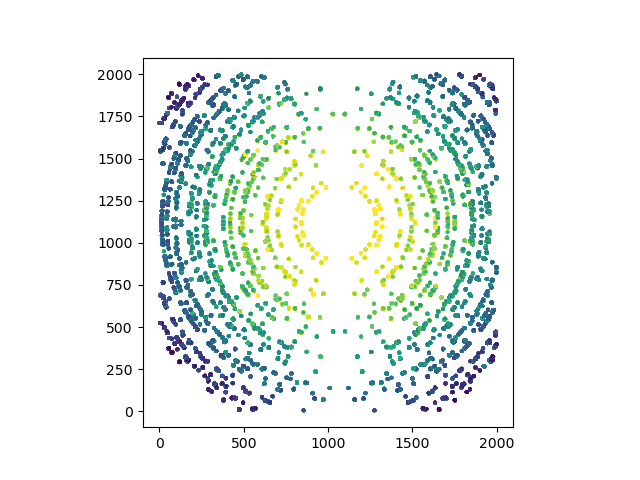

In [66]:
%matplotlib ipympl

fig, ax = plt.subplots()
ax.scatter(res[:, 1], res[:, 0], s=3, c=res[:, -1], norm='log', vmax=10_000)
# ax.set_xlim(1240, 1270)
# ax.set_ylim(1220, 1250)
ax.set_aspect(1)
plt.show()

In [67]:
inten_reshape.max()

6217.362468269752

In [68]:
inten_calc.max()

Array(6217.36246827, dtype=float64)

In [69]:
sc_calc, fc_calc, dty_calc, omega_calc, inten_calc = res.T

In [70]:
omega_calc.min(), omega_calc.max()

(Array(-179.79994458, dtype=float64), Array(179.89969521, dtype=float64))

In [71]:
import fast_histogram
bins = len(obincens), len(ybincens)
omin_edge = omin - ostep / 2
omax_edge = omax + ostep / 2
rng = (
            (omin_edge, omax_edge),
            (ybinedges[0], ybinedges[-1]),
        )
whole_sample_sino = fast_histogram.histogram2d(omega_calc.ravel(), dty_calc.ravel(), weights=np.log(inten_calc), bins=bins, range=rng)
om_edges = np.linspace(rng[0][0], rng[0][1], bins[0])
dty_edges = np.linspace(rng[1][0], rng[1][1], bins[1])

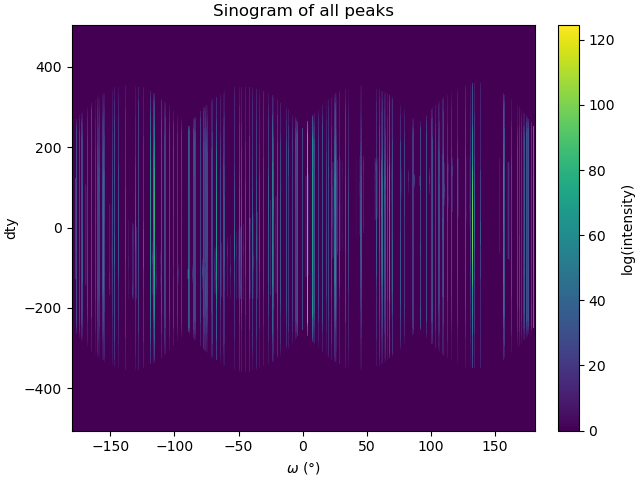

In [72]:
from ImageD11.sinograms.dataset import DataSet

fig, ax = plt.subplots(layout='constrained')
whole_sample_sino = whole_sample_sino.T
pcm = ax.pcolormesh(om_edges, dty_edges, whole_sample_sino)
ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Sinogram of all peaks')
cax = fig.colorbar(pcm, ax=ax, label='log(intensity)')
plt.show()

In [73]:
cf = ImageD11.columnfile.columnfile(new=True)
cf.nrows = len(sc_calc)

In [74]:
inten_calc.shape

(485618,)

In [75]:
cf.addcolumn(sc_calc, 'sc')
cf.addcolumn(fc_calc, 'fc')
cf.addcolumn(omega_calc, 'omega')
cf.addcolumn(dty_calc, 'dty')
cf.addcolumn(inten_calc, 'sum_intensity')
cf.parameters = pars
cf.updateGeometry()

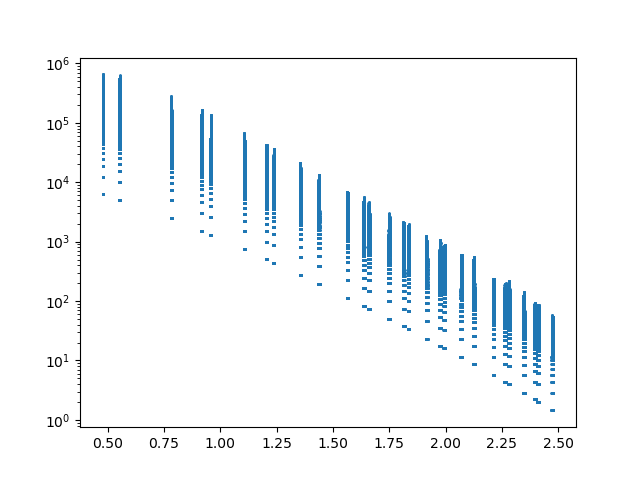

In [76]:
fig, ax = plt.subplots()
ax.scatter(cf.ds, cf.sum_intensity, s=1)
ax.set(yscale='log')
plt.show()

In [77]:
def prepare_peaks_from_2d(grain, cf_2d, grain_label, hkltol=0.25):
    """Prepare peaks used for sinograms from 2D peaks data
       Performs greedy assignment of all 2d peaks to each grain"""

    # get all g-vectors from columnfile
    gv = np.transpose((cf_2d.gx, cf_2d.gy, cf_2d.gz)).astype(float)

    # column to store the grain labels
    labels = np.zeros(cf_2d.nrows, 'i')

    # column to store drlv2 (error in hkl)
    drlv2 = np.ones(cf_2d.nrows, 'd')

    _ = ImageD11.cImageD11.score_and_assign(grain.ubi, gv, hkltol, drlv2, labels, grain_label)

    mask_2d = labels == grain_label

    # get needed columns in the flt file from the mask (without creating a full new FLT for this grain)
    dty = cf_2d.dty[mask_2d]
    omega = cf_2d.omega[mask_2d]
    gx = cf_2d.gx[mask_2d]
    gy = cf_2d.gy[mask_2d]
    gz = cf_2d.gz[mask_2d]
    eta = cf_2d.eta[mask_2d]
    sum_intensity = cf_2d.sum_intensity[mask_2d]

    cf_dict = {"dty": dty,
               "omega": omega,
               "gx": gx,
               "gy": gy,
               "gz": gz,
               "eta": eta,
               "sum_intensity": sum_intensity}

    grain_flt = ImageD11.columnfile.colfile_from_dict(cf_dict)

    cf_for_sino = grain_flt
    return cf_for_sino

In [78]:
cf_base = prepare_peaks_from_2d(base_grain, cf, 0, hkltol=0.01)
cf_twin = prepare_peaks_from_2d(twin_grain, cf, 0, hkltol=0.01)

In [79]:
cf_base.nrows, cf_twin.nrows

(392508, 162587)

In [80]:
def build_sinogram(grain, cf_for_sino, ybincens, columns=('omega',)):
    """
    Computes sinogram for this grain using all peaks in self.cf_for_sino

    columns = list of columns to produce sinograms of intensity*value
            for example: "ds", "eta", "omega", etc
    """
    for a in columns:
        assert a in cf_for_sino.titles
    assert 'omega' in columns

    NY = len(ybincens)  # number of y translations
    iy = np.round(
        (cf_for_sino.dty - ybincens[0]) / (ybincens[1] - ybincens[0])).astype(
        int)  # flt column for y translation index

    hkl = np.round(np.dot(grain.ubi, (cf_for_sino.gx, cf_for_sino.gy, cf_for_sino.gz))).astype(
        int)
    etasigns = np.sign(cf_for_sino.eta)

    # The problem is to assign each spot to a place in the sinogram
    hklmin = hkl.min(axis=1)  # Get minimum integer hkl (e.g -10, -9, -10)
    dh = hkl - hklmin[:, np.newaxis]  # subtract minimum hkl from all integer hkls
    de = (etasigns.astype(int) + 1) // 2  # something signs related
    #   4D array of h,k,l,+/-
    # pkmsk is whether a peak has been observed with this HKL or not
    pkmsk = np.zeros(list(dh.max(axis=1) + 1) + [2, ],
                     int)  # make zeros-array the size of (max dh +1) and add another axis of length 2
    pkmsk[dh[0], dh[1], dh[2], de] = 1  # we found these HKLs for this grain
    #   sinogram row to hit
    print("sinogram row to hit")
    pkrow = np.cumsum(pkmsk.ravel()).reshape(pkmsk.shape) - 1  #
    # counting where we hit an HKL position with a found peak
    # e.g (-10, -9, -10) didn't get hit, but the next one did, so increment
    #
    # found peak indexes into the pkmsk array
    pkhkle = np.arange( np.prod( pkmsk.shape ), dtype=int )[ pkmsk.flat == 1 ]
    # hkl indices (transpose for 3,N versus N,3)
    print('make pkindices')
    pkindices = np.array( np.unravel_index(pkhkle, pkmsk.shape) )
    pkindices[:3] += hklmin[:,np.newaxis]
    print('made pkindices')
    npks = pkmsk.sum()
    destRow = pkrow[dh[0], dh[1], dh[2], de]
    sino = np.zeros((npks, NY), 'f')
    hits = np.zeros((npks, NY), 'f')
    adr = destRow * NY + iy
    # Just accumulate
    sig = cf_for_sino.sum_intensity
    ImageD11.cImageD11.put_incr64(sino, adr, sig)
    ImageD11.cImageD11.put_incr64(hits, adr, np.ones(len(de), dtype='f'))
    print("intensity weighted sums")
    # intensity weighted sums
    angs = {}
    for name in columns:
        if name == 'sum_intensity':
            continue
        angs[name] = np.zeros((npks, NY), 'f')
        ImageD11.cImageD11.put_incr64(angs[name], adr, cf_for_sino[name] * sig )
    sinoangles = angs['omega'] .sum(axis=1) / sino.sum(axis=1)
    # Normalise:
    proj_scale = sino.max(axis=1)
    sino = sino / proj_scale[:, np.newaxis]
    # Sort (cosmetic):
    order = np.lexsort((np.arange(npks), sinoangles))
    sinoangles = sinoangles[order]
    ssino = sino[order].T
    proj_scale = proj_scale[order]
    if len(columns)>1:
        angle_wt_sinos = { name : angs[name][order].T
                                for name in columns
                                if name != 'sum_intensity'
                               }
        if 'sum_intensity' in columns:
            angle_wt_sinos['sum_intensity'] = sino[order].T
    hits = hits
    hkle = pkindices[:, order]  # dims are [ (h,k,l,sign(eta)) , nprojections ]

    return ssino, sinoangles

In [81]:
ssino_base, sinoangles_base = build_sinogram(base_grain, cf_base, ybincens)
ssino_twin, sinoangles_twin = build_sinogram(twin_grain, cf_twin, ybincens)

sinogram row to hit
make pkindices
made pkindices
intensity weighted sums
sinogram row to hit
make pkindices
made pkindices
intensity weighted sums


In [82]:
%matplotlib ipympl

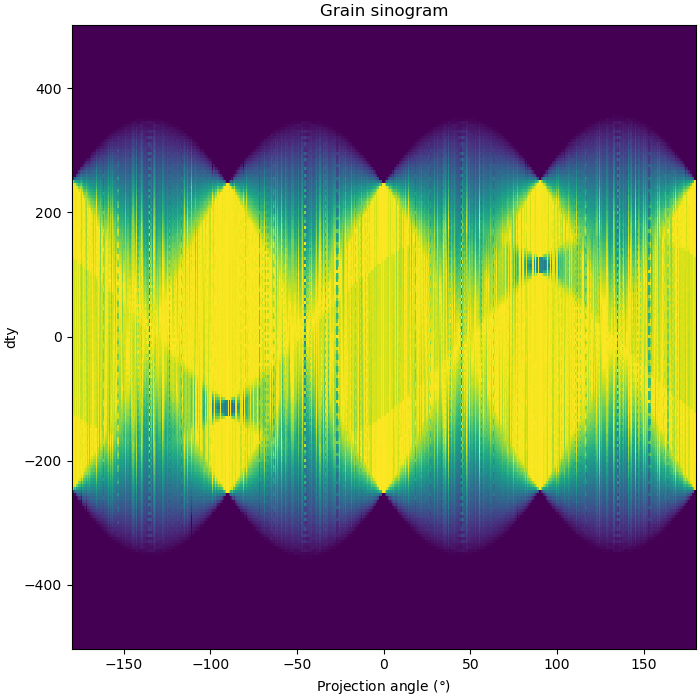

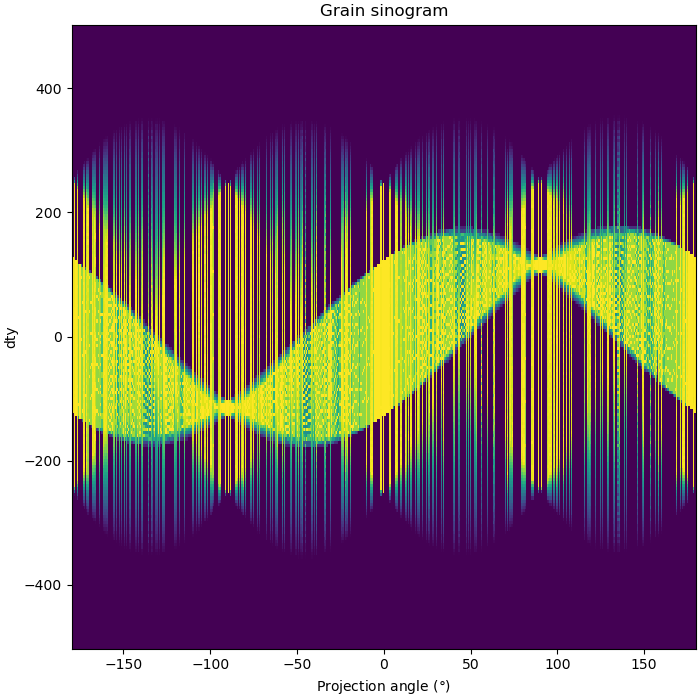

In [83]:
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(sinoangles_base, ybincens, ssino_base)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(sinoangles_twin, ybincens, ssino_twin)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

In [84]:
from ImageD11.sinograms.sinogram import run_astra

In [85]:
recon_base = run_astra(ssino_base, sinoangles_base, mask=None, astra_method='EM_CUDA', pad=0, shift=0)
recon_twin = run_astra(ssino_twin, sinoangles_twin, mask=None, astra_method='EM_CUDA', pad=0, shift=0)

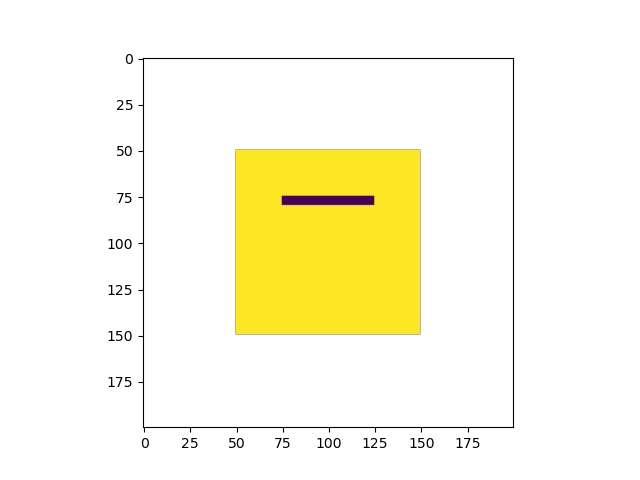

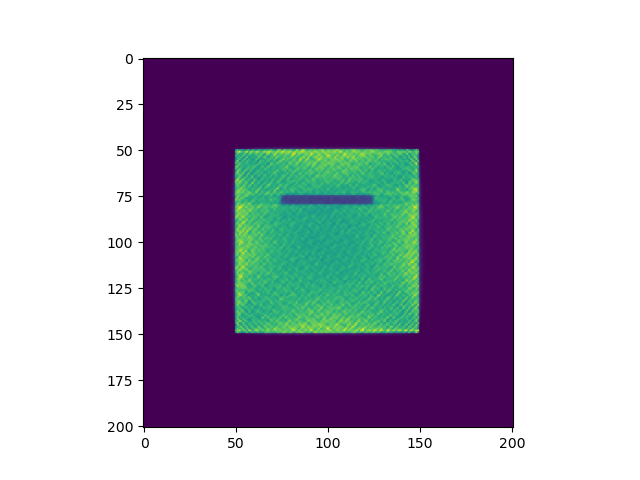

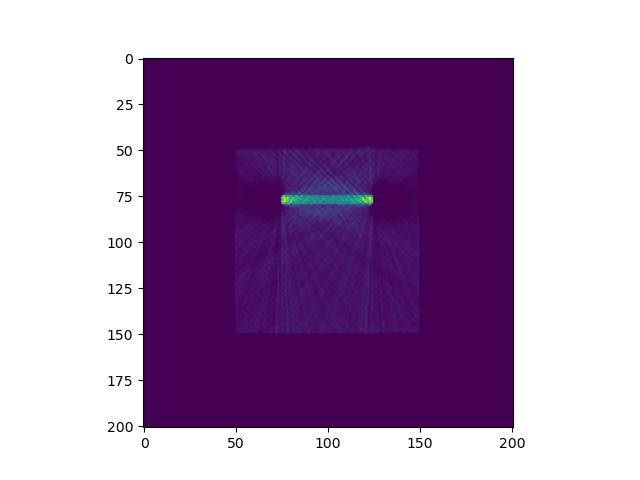

In [86]:
fig, ax = plt.subplots()
ax.imshow(UB_field[..., 0, 0])
plt.show()

fig, ax = plt.subplots()
ax.imshow(recon_base/recon_base.max(), vmin=0)
plt.show()

fig, ax = plt.subplots()
ax.imshow(recon_twin/recon_twin.max(), vmin=0)
plt.show()

In [87]:
UB_field.shape, recon_twin.shape

((200, 200, 3, 3), (201, 201))

In [88]:
# todo
# intensity-weighted histogram into (detector, ybin, obin) space
# detector images should then be "clean"

In [89]:
# !rm twin_test.h5
# ImageD11.columnfile.colfile_to_hdf(cf, 'twin_test.h5')